In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

<hr>
load pretrained model

In [2]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [5]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('../data/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('../data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [6]:
b=graph_dataset[0]
g=b[0]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[26], edge_index=[2, 650], u=[1, 2], x=[26, 48], y=[1, 2])

end of get data<hr>

functions copied from `src.util`

In [7]:
def copy_layer(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp

In [8]:
copy_tensor=lambda x: torch.tensor(x.clone().detach().numpy(),requires_grad=True,dtype=torch.float32)

In [9]:
for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            print(n,j.__repr__())

edge_mlp.0 Linear(in_features=96, out_features=128, bias=True)
edge_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
edge_mlp.2 ReLU()
edge_mlp.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_1.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_1.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_1.2 ReLU()
node_mlp_1.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_2.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_2.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_2.2 ReLU()
node_mlp_2.3 Linear(in_features=128, out_features=128, bias=True)
global_mlp.0 Linear(in_features=128, out_features=128, bias=True)
global_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
global_mlp.2 ReLU()
global_mlp.3 Linear(in_features=128, out_features=2, bias=True)


layer name `n` ends with 0-2 -> joint together, rectified linear layer
layer name `n` ends with 3 -> standalone linear layer

`R2` (`node_mlp_1.0-2`) and `R4` (`node_mlp_2.0-2`) contains partial relevance score of input `x`

In [10]:
layers={}
cnt=0
for i in (model.interactionnetwork.children()):
    layer=[]
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            if n[-1] in ["0","1","2"]:
                layer.append(copy_layer(j))
            else:
                layers[f"L{cnt}"]=Seq(*layer)
                layer=[]
                cnt+=1
                
                layers[f"L{cnt}"]=copy_layer(j)
                cnt+=1
layers

{'L0': Sequential(
   (0): Linear(in_features=96, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L1': Linear(in_features=128, out_features=128, bias=True),
 'L2': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L3': Linear(in_features=128, out_features=128, bias=True),
 'L4': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L5': Linear(in_features=128, out_features=128, bias=True),
 'L6': Sequential(
   (0): Linear(in_features=128, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L7': Linear(in_features=128, out_features=2, bias=True)}

In [11]:
row,col=g.edge_index
n_tracks=g.x.shape[0]
x=nn.BatchNorm1d(48)(g.x)
x=copy_tensor(torch.cat([x[row],x[col]],1))

In [12]:
activations={}
activations["a0"]=layers["L0"].forward(x)

In [13]:
M_col=torch.zeros(col.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(col):
    M_col[i,j]=1
M_col=M_col.T

In [14]:
M_row=torch.zeros(row.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(row):
    M_row[i,j]=1
M_row=M_row.T

In [305]:
for i in range(1,len(layers.keys())):
    if i==2:
        #a1->a1'
        a=copy_tensor(torch.cat([g.x[row],activations[f"a{i-1}"]],1))           # [x[row],a1]
    elif i==4:
        #a3->a3'
#         a=copy_tensor(torch.cat([g.x,M_col@activations[f"a{i-1}"]/n_tracks],1)) # g.x,scatter_mean(a3,col,dim=0)
        a=copy_tensor(torch.cat([g.x,
                                 scatter_mean(activations[f"a{i-1}"], col, dim=0, dim_size=g.x.size(0))
                                ],1)) # g.x,scatter_mean(a3,col,dim=0)
    elif i==6:
        #a5->a5'
        layers[f"L{i}"].eval()
        a=copy_tensor(scatter_mean(activations[f"a{i-1}"],g.batch,dim=0))   # mean of all tracks
    else:
        a=copy_tensor(activations[f"a{i-1}"])
    
    activations[f"a{i}"]=layers[f"L{i}"].forward(a)

In [306]:
for k in activations.keys():
    print(k,activations[k].shape)

a0 torch.Size([1406, 128])
a1 torch.Size([1406, 128])
a2 torch.Size([1406, 128])
a3 torch.Size([1406, 128])
a4 torch.Size([38, 128])
a5 torch.Size([38, 128])
a6 torch.Size([1, 128])
a7 torch.Size([1, 2])


In [307]:
u=activations["a7"]

R={}
R[f"R{8}"]=copy_tensor(u@torch.tensor([[0,0],[0,1]],dtype=torch.float32))
R

{'R8': tensor([[ 0.0000, -1.6464]], requires_grad=True)}

In [308]:
def LRP(a,l,r,epsilon=1e-9):
    a=torch.tensor(a.clone().detach().numpy(),
                      requires_grad=True,dtype=torch.float32)
    a.retain_grad()
    
    z=l.forward(a)
    s=r/(z+epsilon)
    
    (z*s.data).sum().backward()
    c=a.grad
    
    return a*c

In [309]:
activations["a-1"]=x

for i in range(len(layers.keys())-1,-1,-1):
    a=activations[f"a{i-1}"]
    r=R[f"R{i+1}"]
    l=layers[f"L{i}"]
  
    if i==2:
        # a1->a1'
        a=copy_tensor(torch.cat([g.x[row],a],1))
        r=LRP(a,l,r)
        
        # r_x[row],r2'
        r_src,r=r[:,:48],r[:,48:] 
        R[f"R{i}_src"]=r_src

    elif i==4:
        # a3->a3'
        a=copy_tensor(torch.cat([g.x,M_col@a/n_tracks],1))
        r=LRP(a,l,r)
        
        r_x,r=r[:,:48],r[:,48:]
        R[f"R{i}_x"]=r_x
        r=r[col]/n_tracks
    elif i==6:
        # a5->a5'
        a=copy_tensor((torch.ones(1,n_tracks)@a/n_tracks))
        r=LRP(a,l,r)
        
    else:
        a=copy_tensor(a)
        r=LRP(a,l,r)
        
    R[f"R{i}"]=r

In [310]:
for k in R.keys():
    print(k,R[k].shape,R[k].sum())

R8 torch.Size([1, 2]) tensor(-1.6464, grad_fn=<SumBackward0>)
R7 torch.Size([1, 128]) tensor(-1.7142, grad_fn=<SumBackward0>)
R6 torch.Size([1, 128]) tensor(1.8872, grad_fn=<SumBackward0>)
R5 torch.Size([38, 128]) tensor(60.1712, grad_fn=<SumBackward0>)
R4_x torch.Size([38, 48]) tensor(-0.0594, grad_fn=<SumBackward0>)
R4 torch.Size([1406, 128]) tensor(0.0576, grad_fn=<SumBackward0>)
R3 torch.Size([1406, 128]) tensor(8.2001, grad_fn=<SumBackward0>)
R2_src torch.Size([1406, 48]) tensor(-1.8433, grad_fn=<SumBackward0>)
R2 torch.Size([1406, 128]) tensor(1.8433, grad_fn=<SumBackward0>)
R1 torch.Size([1406, 128]) tensor(1.8433, grad_fn=<SumBackward0>)
R0 torch.Size([1406, 96]) tensor(2.0415e-05, grad_fn=<SumBackward0>)


In [312]:
R["R0"]

tensor([[-0.0005,  0.0011, -0.0015,  ...,  0.0007,  0.0006,  0.0000],
        [-0.0007,  0.0008, -0.0013,  ...,  0.0006,  0.0003,  0.0000],
        [-0.0005,  0.0011, -0.0015,  ...,  0.0005,  0.0012,  0.0000],
        ...,
        [-0.0006,  0.0015,  0.0002,  ...,  0.0007, -0.0009,  0.0000],
        [-0.0010,  0.0010,  0.0010,  ...,  0.0003, -0.0008,  0.0000],
        [-0.0006,  0.0017,  0.0008,  ...,  0.0019, -0.0007,  0.0000]],
       grad_fn=<MulBackward0>)

In [313]:
r=(((M_row@R["R0"][:,:48]))+(M_row@R["R2_src"])+R["R4_x"])
r.shape,r.sum()

(torch.Size([38, 48]), tensor(-1.2532, grad_fn=<SumBackward0>))

<hr>

## Plot

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [253]:
sns.set(style="white")

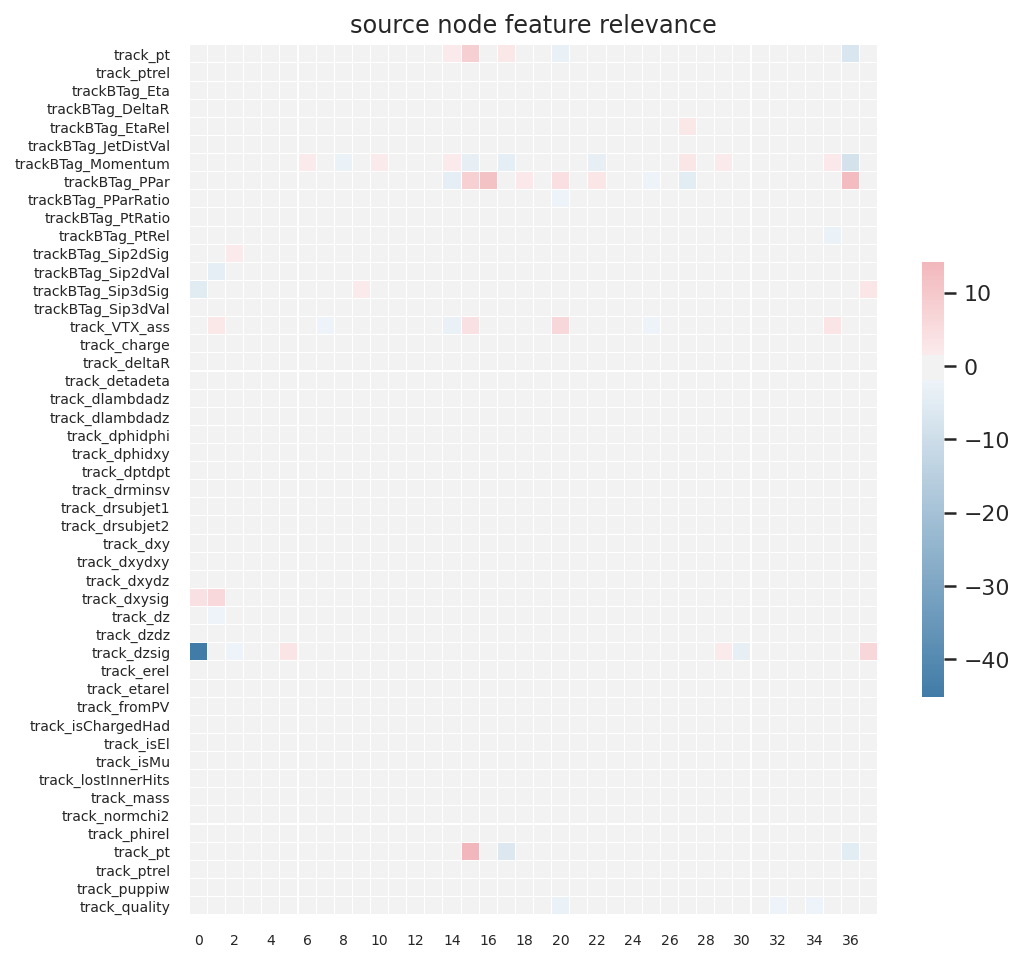

In [314]:
val=r.detach().cpu().numpy()
df=pd.DataFrame(val,columns=features).T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s=sns.heatmap(df, cmap=cmap, center=0,yticklabels=1,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})

s.tick_params(labelsize=7)

plt.title("source node feature relevance")
plt.show()

<hr>

In [329]:
node_shade=torch.norm(M_row@R["R0"][:,:48],dim=1)
node_shade

tensor([0.1846, 1.8953, 0.4259, 0.9780, 0.1497, 0.1337, 0.5048, 0.1560, 0.5757,
        0.2461, 0.1648, 0.1180, 0.0583, 0.1172, 0.1660, 0.3022, 0.1734, 0.0818,
        0.4746, 0.3371, 1.6693, 0.5923, 0.3630, 0.4513, 0.3118, 0.1590, 0.4706,
        0.8376, 0.2563, 0.4149, 0.2004, 0.0725, 0.1184, 0.1962, 0.4365, 0.3362,
        0.3344, 0.1922], grad_fn=<NormBackward3>)

In [330]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import networkx as nx
import matplotlib.colors as colors

In [372]:
def network_plot_3D(G, angle,label, edge_alpha,save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    node_shade=nx.get_node_attributes(G,"node_shade")
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
#     edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
#     colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            ax.scatter(xi, yi, zi, c='k',s=25*node_shade[key], edgecolors='orange', alpha=0.5)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        weight=list(nx.get_edge_attributes(G, 'edge_shade').values())
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(weight), vmax=max(weight)))
        for i,j in enumerate(G.edges()):

            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            
#             ax.plot(x, y, z, c=sm.to_rgba(weight[i]), alpha=edge_alpha[i])
            ax.plot(x, y, z, c='b', alpha=edge_alpha[i])
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
#     ax.set_axis_off()
    plt.xlabel("track_etarel")
    plt.ylabel("track_phirel")
    plt.title(f"jet label: {label}")
    plt.show()

    plt.show()
    
    return

In [365]:
edge_shade=torch.norm(R["R0"],dim=1)
alpha=(edge_shade-edge_shade.min())/edge_shade.max()
alpha=alpha.detach().numpy()

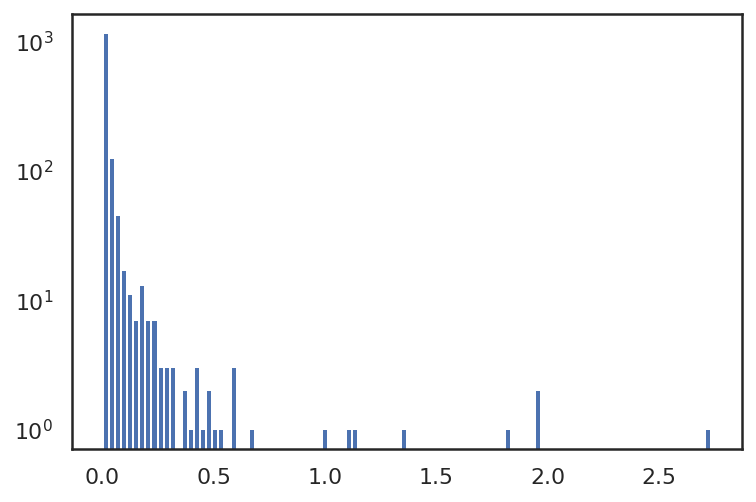

In [343]:
plt.hist(edge_shade.detach().numpy(),bins=100,log=True)
plt.show()

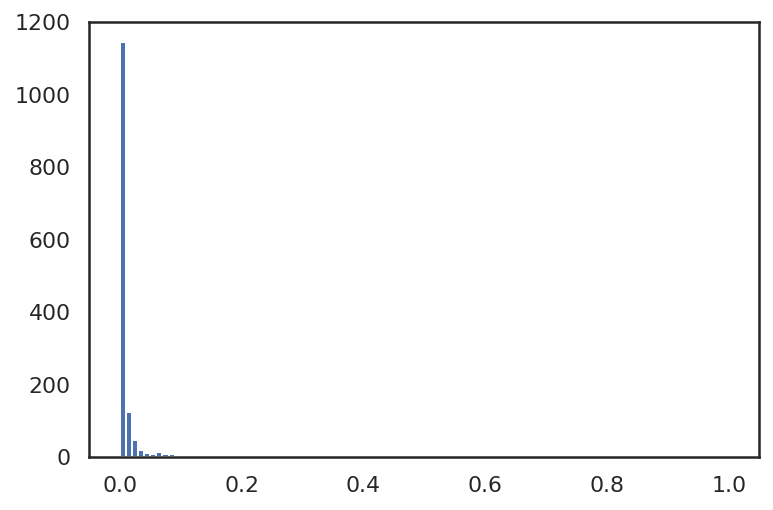

In [371]:
plt.hist(alpha,bins=100)
plt.show()

In [345]:
g.edge_shade=edge_shade
g.node_shade=node_shade

pos=np.array(list(zip(g.x[:,eta_idx].detach().numpy(),g.x[:,phi_idx].detach().numpy(),g.x[:,0].detach().numpy())))
g.pos=pos

In [347]:
from torch_geometric.utils import to_networkx

In [348]:
G = to_networkx(g, edge_attrs=['edge_shade'],node_attrs=["pos","node_shade"])

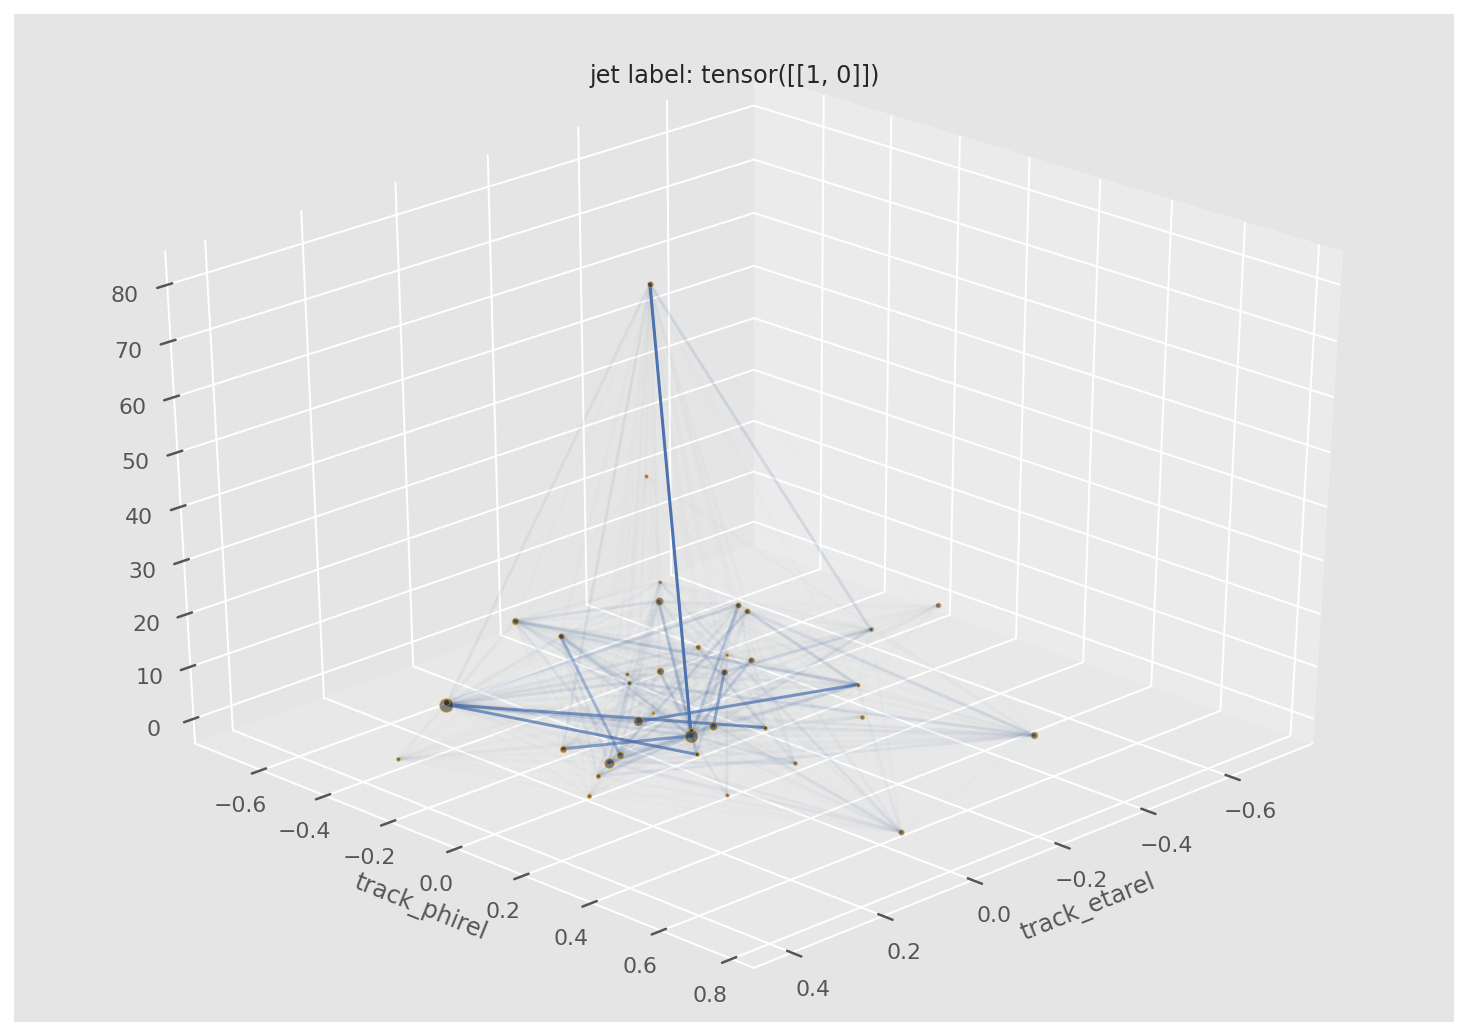

In [373]:
network_plot_3D(G,45,g.y.detach(),alpha)